In [2]:
import dataIO

In [3]:
import lasagne
import theano
import theano.tensor as T
import numpy as np;
import time

from const import *;

# create Theano variables for input and target minibatch
sentence1 = T.ftensor3('s1')
sentence2 = T.ftensor3('s2')
mask1 = T.bmatrix('m1')
mask2 = T.bmatrix('m2')
target_var = T.ivector('ent')
MAX_BATCHES = 5000


In [7]:
# create a small convolutional neural network
from lasagne.nonlinearities import leaky_rectify, softmax
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, LSTMLayer, ConcatLayer, DenseLayer, dropout, Conv1DLayer, ReshapeLayer



def createNeuralNetwork():
    #(batchsize, sequence length, onehot vector length)
    in1 = InputLayer((None, None, kNUM_CHARS), sentence1)
    in2 = InputLayer((None, None, kNUM_CHARS), sentence2)
    l_mask1=lasagne.layers.InputLayer((None,None), mask1)
    l_mask2=lasagne.layers.InputLayer((None,None), mask2)

    num_LSTM_output = (512)
    lstm1_f = LSTMLayer(in1, num_LSTM_output,
        forgetgate=lasagne.layers.Gate(),
        nonlinearity=lasagne.nonlinearities.tanh,
        cell_init=lasagne.init.Constant(0.),
        hid_init=lasagne.init.Constant(0.), grad_clipping=kGRAD_CLIP,
        backwards=False,
        mask_input=l_mask1,
        only_return_final=True)
    lstm1_b = LSTMLayer(in1, num_LSTM_output,
        forgetgate=lasagne.layers.Gate(),
        nonlinearity=lasagne.nonlinearities.tanh,
        cell_init=lasagne.init.Constant(0.),
        hid_init=lasagne.init.Constant(0.), grad_clipping=kGRAD_CLIP,
        backwards=True,
        mask_input=l_mask1,
        only_return_final=True)

    lstm2_f = LSTMLayer(in2, num_LSTM_output,
        forgetgate=lasagne.layers.Gate(),
        nonlinearity=lasagne.nonlinearities.tanh,
        cell_init=lasagne.init.Constant(0.),
        hid_init=lasagne.init.Constant(0.), grad_clipping=kGRAD_CLIP,
        backwards=False,
        mask_input=l_mask2,
        only_return_final=True)
    lstm2_b = LSTMLayer(in2, num_LSTM_output,
        forgetgate=lasagne.layers.Gate(),
        nonlinearity=lasagne.nonlinearities.tanh,
        cell_init=lasagne.init.Constant(0.),
        hid_init=lasagne.init.Constant(0.), grad_clipping=kGRAD_CLIP,
        backwards=True,
        mask_input=l_mask2,
        only_return_final=True)

    network = ConcatLayer([lstm1_f, lstm1_b, lstm2_f, lstm2_b], axis=1) #(NONE-sentencesize by 2048)
    network = ReshapeLayer(network, (-1, 1, 4, num_LSTM_output));
    #(None by 4x512) I think.
    cv2d = Conv2DLayer(network, 15, (3,3), pad='same',
                                         nonlinearity=leaky_rectify)
    #(20 by 4 by 52)
    network = Conv2DLayer(cv2d, 10, (3,3), pad='same',
                                         nonlinearity=leaky_rectify)

    network = lasagne.layers.MaxPool2DLayer(network, (4,4), stride=2)

    network = DenseLayer(dropout(network, 0.5),
                                        128, nonlinearity=leaky_rectify,
                                        W=lasagne.init.Orthogonal())

    network = DenseLayer(dropout(network, 0.5), 3, nonlinearity=softmax)

    return network, cv2d;


network, cv2d = createNeuralNetwork();


In [30]:
def loadDriverModelFromFile(filename):
    print "Loading Neural Network Values from File"
    _v = np.load(filename)['model']
    lasagne.layers.set_all_param_values(network, _v)
    if type(filename)==str:
        print "LOADED"
        return;
    print "Loaded!"

with open("./modelStore/0606-202105-E0.pkl", 'r') as f:
    loadDriverModelFromFile(f)


Loading Neural Network Values from File
Loaded!


In [17]:


print "HOLY SHIT IT COMPILED"
# create loss function
prediction = lasagne.layers.get_output(network)
print "HOLY SHIT IT COMPILED OUTPUT"

loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
        network, lasagne.regularization.l2)
print "HOLY SHIT IT COMPILED LOSS FUNCTION WHAT"

# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01,
                                            momentum=0.9)
print "HOLY SHIT IT COMPILED UPDATES"

# compile training function that updates parameters and returns training loss
train_fn = theano.function([sentence1, sentence2, mask1, mask2, target_var], loss, updates=updates, allow_input_downcast=True)
# train_fn = theano.function([sentence1, sentence2, target_var], loss, updates=updates)
print "HOLY SHIT IT COMPILED TRAINING FUNCTION"



HOLY SHIT IT COMPILED
HOLY SHIT IT COMPILED OUTPUT
HOLY SHIT IT COMPILED LOSS FUNCTION WHAT
HOLY SHIT IT COMPILED UPDATES
HOLY SHIT IT COMPILED TRAINING FUNCTION


done compiling...
reading 
[[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  1.  0.  0.]]]
(1, 54, 30)
(1, 54, 30)


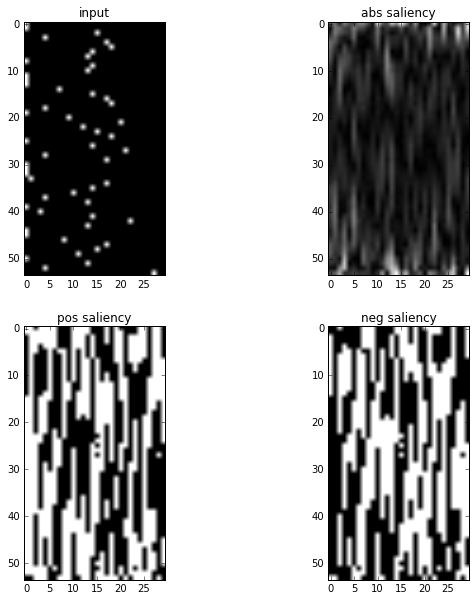

In [33]:
#ANALYSIS SYSTEM:

def compile_saliency(net):
    print "generating output"
    output = lasagne.layers.get_output(net,deterministic=True)
    max_out = T.max(output, axis=1)
    saliency = theano.grad(max_out.sum(), wrt=sentence1)
    print "compiling..."
    return theano.function([sentence1, sentence2, mask1, mask2], [saliency, output])

def showImg(imgOrig,sal,max_class,title):
#     sal = sal[0]
    max_class = max_class[0]
    sal = sal[::-1].transpose(1,2,0)
    print imgOrig.shape
    imgOrig = imgOrig[::-1].transpose(1,2,0)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(10,10),facecolor='w')
    plt.subplot(2,2,1)
    plt.title('input')
    plt.imshow(np.abs(imgOrig).max(axis=-1), cmap='gray')
    plt.subplot(2,2,2)
    plt.title("abs saliency")
    plt.imshow(np.abs(sal).max(axis=-1),cmap='gray')
    plt.subplot(2,2,3)
    plt.title("pos saliency")
    plt.imshow(np.maximum(0, sal).max(axis=-1)/sal.max(axis=-1), cmap='gray')
    plt.subplot(2,2,4)
    plt.title("neg saliency")
    plt.imshow(np.maximum(0, -sal).max(axis=-1)/(-sal.min(axis=-1)), cmap='gray')
    plt.show()

#sal_fn = compile_saliency(network)

def runSaliencyAnalysis():
    print "done compiling..."
    for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_train.txt'):
        print batch1
        saliency,maxclass = sal_fn(batch1, batch2, m1, m2)
        print saliency.shape
        showImg(batch1,saliency,maxclass,"Saliency");
        break;


runSaliencyAnalysis();


In [25]:
with open('./snli_1.0/snli_1.0_train.txt') as f:
    
    
    print "reading "
    f.readline();
    for l in f:
        l=l.strip().split("\t")
        print l[5], l[6], l[0]
        break;
#         print sentence_to_onehots(l[3]), sentence_to_onehots(l[4]), golds[l[0]]

#     f.readline();
#     print f.readline();
#     print dataIO.char_to_onehot('h')
#     print dataIO.sentence_to_onehots("A person")
    print dataIO.padZeroes([[[1,]+[0,]*29,[0,1]+[0,]*28]], 7)[0].shape
print len("A person is training his horse for a competition.")
print len("A person on a horse jumps over a broken down airplane.")
print len("(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .)))	(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))")
for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_train.txt'):
    print batch1.shape
    break;

X1 = [];
X2 = [];
maxLen1 = 0;
maxLen2 = 0;
for x1,x2,y in dataIO.readData('./snli_1.0/snli_1.0_train.txt'): #(?,NUM_CHAR)
    print x1;
    print x1.shape
    print "------------"
    print x2;
    print x2.shape
    print "------------"
    X1.append(x1)
    X2.append(x2)
    maxLen1 = max(len(x1), maxLen1)
    maxLen2 = max(len(x2), maxLen2)
    print maxLen1
    print maxLen2
    break;


reading 
A person on a horse jumps over a broken down airplane. A person is training his horse for a competition. neutral
(1, 7, 30)
49
54
306
reading 
(1, 161, 30)
reading 
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
(161, 30)
------------
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
(144, 30)
------------
161
144


In [ ]:
# train network (assuming you've got some training data in numpy arrays)

def makeMask(batch): #list of matricies of variable size.
    m = np.zeros((len(batch), max([b.shape[0] for b in batch])))
    for i,b in enumerate(batch):
        m[i, 0:b.shape[0]] = 1.0
    return m;

for epoch in range(10):
    batchCount = 0
    loss = 0
    print "HOLY SHIT IT EPOCHS!"
    #for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_train.txt'):
    for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_train.txt'):
        #         if batchCount >= kMAX_BATCHES:
        #             break
        # import code
        # code.interact(local=locals())
        # print batch1.shape, batch2.shape, ys.shape
        # loss += train_fn(batch1, batch2, makeMask(batch1), makeMask(batch2), ys)
        loss += train_fn(batch1, batch2, m1, m2, ys)
        batchCount += 1
        if batchCount > 8000:
            break

    print("Epoch %d: Loss %g" % (epoch + 1, loss / batchCount))
   
    vals = lasagne.layers.get_all_param_values(network)
    modelFile = open("modelStore/"+time.strftime("%m%d-%H%M%S")+"-E"+str(epoch)+".pkl", mode="w")    
    np.savez(modelFile, model=vals)
    print ">>>", modelFile.name
    modelFile.close()
    print "Done."


In [ ]:
vals = lasagne.layers.get_all_param_values(network)
modelFile = open("modelStore/"+time.strftime("%m%d-%H%M%S")+".pkl", mode="w")    
np.savez(modelFile, model=vals)
print ">>>", modelFile.name
modelFile.close()
print "Done."


In [26]:
# use trained network for predictions
test_prediction = lasagne.layers.get_output(network, deterministic=True)
predict_fn = theano.function([sentence1, sentence2, mask1, mask2], test_prediction)

In [21]:
# Save model
# Check on dev set
batch_num = 0
total_classifications = 0
total_correct = 0
total_incorrect = 0
for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_dev.txt'):
    results = predict_fn(batch1, batch2, m1, m2);
    for i in range(len(results)):
        if results[i] == ys[i]:
            total_correct += 1
        else:
            total_incorrect += 1
        total_classifications += 1
    batch_num += 1
    print batch_num, "\r", 
    #if batch_num == 1666: break


reading 


In [23]:
# Stats print out

print "Total classifications: " + str(total_classifications)
print "Total correct: " + str(total_correct)
print "Total incorrect: " + str(total_incorrect)

Total classifications: 10000
Total correct: 3393
Total incorrect: 6607


In [32]:
# Save model
# Check on test set
batch_num = 0
total_classifications = 0
total_correct = 0
total_incorrect = 0
count = dict()
batch1s = [];
for (batch1,m1), (batch2,m2), ys in dataIO.readChunk(kBATCH_SIZE, './snli_1.0/snli_1.0_train.txt'):
    if batch_num == 5:
        break
    batch1s.append(batch1)
    results = predict_fn(batch1, batch2, m1, m2)
    print results, ys
#     for i in range(len(results)):
#         if results[i] == ys[i]:
#             total_correct += 1
#         else:
#             total_incorrect += 1
#         total_classifications += 1
#         if results[i] in count:
#             count[results[i]] += 1
#         else:
#             count[results[i]] = 1
    batch_num += 1
    print batch_num, "\r", 
print count

reading 
[[ 0.34313923  0.32604912  0.33081168]] [0]
[[ 0.34313917  0.32604912  0.33081168]] [2]
[[ 0.34313899  0.32604921  0.33081186]] [1]
[[ 0.34313902  0.32604918  0.33081174]] [0]
[[ 0.34313887  0.32604933  0.33081186]] [1]
{}


In [25]:
# Stats print out for train set

print "Total classifications: " + str(total_classifications)
print "Total correct: " + str(total_correct)
print "Total incorrect: " + str(total_incorrect)

Total classifications: 8000
Total correct: 2662
Total incorrect: 5338
